In [0]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_rows = 20
import matplotlib.pyplot as plt
import numpy as np

bg = pd.read_excel('/content/drive/My Drive/EEC 193/EEC 193B/Burn_Glucose_022020.xlsx', skiprows = 0)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
bg

,PER_CODE,Collection Date,Time Vitals,Systolic,Diastolic,MAP,HR,RR,Temp,CVP,GCS,Vent,Time_CBC,WBC,Hgb,Hct,Platelet,Time Labs,Na,K_pos,BUN,Creatnine,Glucose,Tbili,Chloride,V_CO2,PaO2,FIO2,PaCO2,HCO3,PH,Sepsis
0,21,2011-01-02,614.0,113.0,67.0,78.0,102.0,15.0,37.0,7.0,15.0,No,5.0,6.9,8.1,24.5,578.0,5.0,136.0,3.6,7.0,0.53,110.0,0.3,101.0,29.0,NaN,NaN,NaN,NaN,NaN,0
1,21,2011-01-03,600.0,137.0,67.0,85.0,105.0,16.0,37.3,7.0,15.0,No,59.0,7.8,7.9,25.1,615.0,59.0,137.0,3.7,8.0,0.55,130.0,0.3,104.0,27.0,NaN,NaN,NaN,NaN,NaN,0
2,21,2011-01-04,1000.0,124.0,56.0,73.0,104.0,18.0,37.5,7.0,15.0,No,208.0,8.9,8.7,26.6,607.0,208.0,135.0,3.4,8.0,0.53,172.0,0.3,103.0,24.0,NaN,NaN,NaN,NaN,NaN,0
3,21,2011-01-05,930.0,143.0,69.0,85.0,104.0,18.0,37.5,7.0,15.0,No,103.0,9.3,8.4,25.7,414.0,103.0,134.0,4.8,10.0,0.49,150.0,0.3,103.0,25.0,NaN,0.21,NaN,NaN,NaN,0
4,21,2011-01-06,1130.0,130.0,59.0,83.0,104.0,23.0,38.0,7.0,15.0,No,130.0,8.4,8.9,27.7,701.0,130.0,136.0,3.5,11.0,0.51,109.0,0.3,103.0,27.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,PCR-004-00018,2013-05-27,600.0,140.0,70.0,102.0,116.0,26.0,38.5,NaN,NaN,No,211.0,17.6,9.2,26.8,454.0,211.0,138.0,4.5,12.0,0.88,139.0,NaN,103.0,25.0,NaN,NaN,NaN,NaN,NaN,0
6537,PCR-004-00018,2013-05-28,600.0,158.0,53.0,82.0,110.0,22.0,37.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6538,PCR-004-00018,2013-05-29,600.0,133.0,51.0,72.0,120.0,22.0,38.5,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6539,PCR-004-00018,2013-05-30,600.0,118.0,49.0,73.0,118.0,22.0,38.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Data Preprocessing ##


In [0]:
def Drop_nan_row(df):
  
  drop_idx = []
  for i in range(len(df)):
    nan_count = 0
    for x in df.loc[i]:
      if str(x) == 'nan':
        nan_count += 1
    if nan_count >= 15:
      drop_idx.append(i)
    
  modified_df = df.drop(df.index[drop_idx], errors = 'ignore')
  modified_df = modified_df.reset_index(drop = True)

  return modified_df

In [0]:
def Drop_unrelated_cols(df):
  df = df.drop(columns = ['PER_CODE', 'Collection Date', 'Time Vitals', 'Time Labs', 'Time_CBC', 'Vent'], errors = 'ignore')
  return df

In [0]:
def Drop_nan_col(df):
  
  num_rows = len(df)
  for x in df:
    num_nan = 0
    for i in df[x]:
      if str(i) == 'nan':
        num_nan += 1
    
    if (num_nan/num_rows) >= 0.2:
      df = df.drop(columns = x, errors = 'ignore')
  
  return df

In [0]:
def Complete_dataset(df):

  # Change "Yes" and "No" under "Vent" to 1 and 0
  df = df.replace('No', 0)
  df = df.replace('Yes', 1)

  # drop nan or replace them with other value
  df = df.dropna()
  df = df.reset_index(drop = True)

  return df

In [0]:
def data_preprocess(df):

  # drop rows that have too many nan
  df = Drop_nan_row(df)
  # drop times and patient ids
  df = Drop_unrelated_cols(df)
  # drop cols that have too many nan
  df = Drop_nan_col(df)
  # Replace all the other nans
  df = Complete_dataset(df)

  return df

In [0]:
bg = data_preprocess(bg)

## Finding Score ##

In [10]:
pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 7.2MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn import svm
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import imblearn

In [0]:
# def Scores_calculation(train_x, train_y, test_x, test_y):
#   precision_scores = [[],[]]
#   recall_scores = [[],[]]
#   f1_score_scores = [[],[]]

#   model = RandomForestClassifier()
#   for i in range(0,10):
#     model.fit(train_x, train_y)
#     predictions = model.predict(test_x)
#     report = classification_report(test_y, predictions, output_dict = True)

#     precision_scores[0].append(report['0']['precision'])
#     recall_scores[0].append(report['0']['recall'])
#     f1_score_scores[0].append(report['0']['f1-score'])
    
#     precision_scores[1].append(report['1']['precision'])
#     recall_scores[1].append(report['1']['recall'])
#     f1_score_scores[1].append(report['1']['f1-score'])

#   precision_scores_avg_0 = sum(precision_scores[0]) / 10
#   recall_scores_avg_0 = sum(recall_scores[0]) / 10
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10

#   precision_scores_avg_1 = sum(precision_scores[1]) / 10
#   recall_scores_avg_1 = sum(recall_scores[1]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

#   # print('0 precision average', precision_scores_avg_0)
#   # print('1 precision average', precision_scores_avg_1)
#   # print('0 recall average', recall_scores_avg_0)
#   # print('1 recall average', recall_scores_avg_1)
#   # print('0 f1_socre average', f1_score_scores_avg_0)
#   # print('1 f1_socre average', f1_score_scores_avg_1)
#   # print('average f1_scores', (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

#   return (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2

## Getting Best Features ##

### Progressive Selection ###

In [0]:
# model = RandomForestClassifier()
# x = bg[['Hct', 'Platelet', 'WBC', 'Glucose']].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)
  
# score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
# print(score)

In [0]:
# model = RandomForestClassifier()
# temp = list(bg.columns)
# temp.remove('Hct')
# temp.remove('Platelet')
# temp.remove('WBC')
# temp.remove('Sepsis')
# temp.remove('Temp')
# temp.remove('RR')
# temp.remove('HR')
# col_use = ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

# for f in temp:
#   g = [f]
#   g = col_use + g

#   x = bg[g].values
#   y = bg['Sepsis'].values
#   train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

#   scaler = RobustScaler()
#   train_x = scaler.fit_transform(train_x)
#   test_x = scaler.transform(test_x)

#   n_minority = len(train_y[train_y == 1])
#   n_majority = int(n_minority * 2.5)
#   sampling_numbers = {0: n_majority, 1: n_minority}

#   rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
#   train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
#   train_y_rus = pd.Series(train_y_rus)
  
#   score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
#   print(g,':',score)
  

Best feature combination: ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

### Regressive Selection ###

In [0]:
# from sklearn.feature_selection import RFE

# col = list(bg.columns)
# col.remove('Sepsis')
# x = bg[col].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)

# estimator = RandomForestClassifier()
# selector = RFE(estimator, 3, step=1)
# selector = selector.fit(train_x_rus, train_y_rus)

# new_train_x = train_x[:, selector.support_]
# new_test_x = test_x[:, selector.support_]

# model = RandomForestClassifier()

# f1_score_scores = [[],[]]

# model = RandomForestClassifier()
# for i in range(0,10):
#   model.fit(new_train_x, train_y)
#   predictions = model.predict(new_test_x)
#   report = classification_report(test_y, predictions, output_dict = True)

#   f1_score_scores[0].append(report['0']['f1-score'])
#   f1_score_scores[1].append(report['1']['f1-score'])
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

# print((f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

3 features: f1_score = 0.5483979297526201 \\
4 features: f1_score = 0.5807557454179925 \\
5 features: f1_score = 0.5788802053854059 \\
6 features: f1_score = 0.5769307206585933 \\
7 features: f1_score = 0.5722500953954065

Random Under Sampling

## Best features + SVM + RFE + RobustScaler##




In [12]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 2.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
model = svm.SVC(kernel="linear", probability=True)
#model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.504002425712553


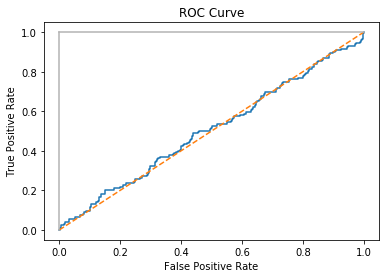

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Over Sampling

In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 40)
sampling_numbers = {0: n_majority, 1: n_minority}

ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy=sampling_numbers)
train_x_ros, train_y_ros = ros.fit_resample(train_x, train_y)
train_y_ros = pd.Series(train_y_ros)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
estimator = svm.SVC(kernel="linear", probability=True)
model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_ros, train_y_ros)
  predictions = model.predict(test_x)
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.42074658041910923


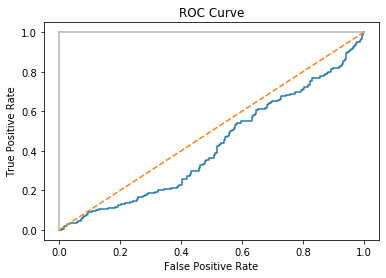

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SMOTE

In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 80)
sampling_numbers = {0: n_majority, 1: n_minority}

smote = imblearn.over_sampling.SMOTE(sampling_strategy=sampling_numbers)
train_x_smote, train_y_smote = smote.fit_resample(train_x, train_y)
train_y_smote = pd.Series(train_y_smote)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
estimator = svm.SVC(kernel="linear", probability=True)
model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_smote, train_y_smote)
  predictions = model.predict(test_x)
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)


f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.5402735664712621


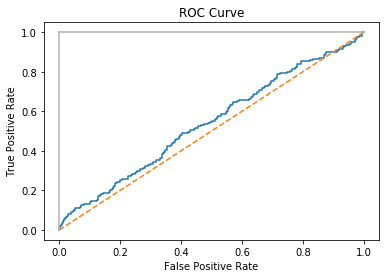

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###RUS###

**Max f1 score ~0.62 ; Max roc_auc_score ~0.69**

---
StandardScaler()  
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  0.4602649006622516
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.6221264189051878

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.5191814975438378 ; roc_auc_score =  0.5458744332658872
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =  f1 score =  0.5325737246934639 ; roc_auc_score =  0.5342142301783573

---
MinMaxScaler()                                                                                    
Linear
*   0.1 test_size: f1 score =  0.46130030959752333
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  0.4603448275862069
*   0.4 test_size: f1 score =  0.46028460543337635
*   0.5 test_size: f1 score =  0.4602649006622516 
*   0.6 test_size: f1 score =  0.4607961399276236
*   0.7 test_size: f1 score =  0.4616632261869655
*   0.8 test_size: f1 score =  0.4621632074255511
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5693158300937032

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.4946494994056566 ; roc_auc_score =  0.5025380086555755
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.46237544382086815; roc_auc_score =  0.5641278976167559

---
MaxAbsScaler()

Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5716119426507243

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.4602649006622516 ; roc_auc_score =  0.508761545451139
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   ;

---
RobustScaler()

Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  0.4607961399276236 ; roc_auc_score =  0.6092428513894482
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  **0.6456016248483868**  (f1 score same every rerun but roc_auc_score changes)
*   9 test_size: f1 score =  

Poly
*   0.1 test_size: f1 score = 0.47633269144286977 ; roc_auc_score =  0.5585682326621924
*   0.2 test_size: f1 score =  0.5300647169656755 ; roc_auc_score =  0.6301832760595647
*   0.3 test_size: f1 score =  0.5485203799423982 ; roc_auc_score =  0.622480052108777
*   0.4 test_size: f1 score =  0.5310767275741736 ; roc_auc_score =  0.39136652183545634
*   0.5 test_size: f1 score =  0.5473666028911565 ; roc_auc_score =  0.6383364011915468
*   0.6 test_size: f1 score =  0.5510387067000565; roc_auc_score =  0.627087460034356
*   0.7 test_size: **f1 score =  0.5597353368321161 ; roc_auc_score =  0.6393125199616735**
*   0.8 test_size: f1 score =  0.5521906701813244 ; roc_auc_score =  0.6177497570560659
*   0.9 test_size: f1 score =  0.5445732222249821 ; roc_auc_score = roc_auc_score =  roc_auc_score =  0.383419908438607
*   9 test_size: f1 score =  0.47058823529411764 ; roc_auc_score =  0.625 (weird graph)

rbf
*   0.1 test_size: f1 score =  0.5545147995503934 ; roc_auc_score =  0.6047129008202834
*  **0.2 test_size: f1 score =  0.5929992948634569 ; roc_auc_score =  0.6524560339599758**
*   0.3 test_size: f1 score =  0.5810169665139495; roc_auc_score =  **0.6848086630841882**
*   0.4 test_size: f1 score =  0.5602990168727221; roc_auc_score =  0.6392164832931431
*   0.5 test_size: f1 score =  0.5763794001309245; roc_auc_score =  0.6436495334982014
*   0.6 test_size: f1 score =  0.5156116669816327; roc_auc_score =  0.662561335448396
*   0.7 test_size: f1 score =  0.5696377980920485 ; roc_auc_score =  0.653539051175589
*   0.8 test_size: f1 score =  0.5856427106933392 ; roc_auc_score =  0.653539051175589
*   0.9 test_size: f1 score =  0.5560158903558627 ; roc_auc_score = roc_auc_score =  0.6602026762341794 
*   9 test_size: f1 score =  0.47058823529411764
*   1000 test_size: f1 score =  0.5570351246687955 ; roc_auc_score =  0.6724271185461269

n_minority * 2
*   0.3 test_size: f1 score =  0.6271494154290176 ; roc_auc_score =  0.6765429083211203

n_minority * 1.5
*   0.2 test_size: f1 score =  0.6313219934915585 ; roc_auc_score =  0.6800384071154234
*   0.3 test_size: **f1 score =  0.6287053155865038; roc_auc_score =  0.6934147532975083**
*   0.3 test_size: f1 score =  0.6186412865113227 ; roc_auc_score =  0.7007821967610444

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  0.5013969482054589
*   0.2 test_size: f1 score =  0.5142429586874032
*   0.3 test_size: f1 score =  0.523319624726899
*   0.4 test_size: f1 score =  0.5270204378711177
*   **0.5 test_size: f1 score =  0.5359314286678617**
*   0.6 test_size: f1 score =  0.538059820921319
*   0.7 test_size: f1 score =  0.5142999814911929
*   0.8 test_size: f1 score =  0.4973805976886962
*  0.9 test_size: f1 score =   0.5288918158405201
*  9 test_size:   f1 score =  0.4375
*  999 test_size:   f1 score = 0.53994708994709 ; roc_auc_score =  0.5450541662448112


---
PowerTransformer()
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5755157110276367

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.5177548442918647 ; roc_auc_score =  0.486890760828837
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.503991162626158; roc_auc_score =  0.5201247290568332


---
QuantileTransformer()
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.6181020009357884
*   9 test_size: f1 score =  0.47058823529411764 ;

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.49272039290382863 ; roc_auc_score =  0.4941195481115107
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.4902198249673151 ; roc_auc_score =  0.5226466825697911


In [362]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

#scaler = StandardScaler() 
#scaler = MinMaxScaler() 
#scaler = MaxAbsScaler() 
scaler = RobustScaler() 
#scaler = PowerTransformer() 
#scaler = QuantileTransformer() 

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 1.75)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
model = svm.SVC(kernel="rbf", probability=True)
#model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.6331053351573188
sensitivity =  0.62175055589246
specificity =  0.62175055589246


roc_auc_score =  0.6711407587089819


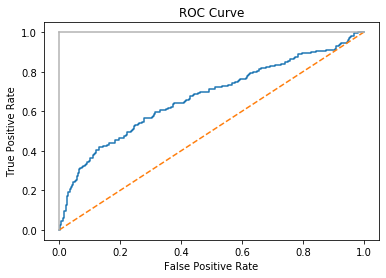

In [363]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [191]:
count_0 = 0
count_1 = 0
for x in bg.Sepsis.values:
  if int(x) == 1:
    count_1 += 1
  else:
    count_0 += 1

print(count_0)
print(count_1)

4476
739


 predict_proba: predicts the probabilities of various classes